In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
generation_df = pd.read_csv("data/Plant_2_Generation_Data.csv")

In [3]:
generation_df.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.0,520758.0
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.0,121131356.0
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.0,2427691.0
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.0,106896394.0
67697,2020-06-17 23:45:00,4136001,xoJJ8DcxJEcupym,0.0,0.0,4316.0,209335741.0


In [4]:
weather_df = pd.read_csv("data/Plant_2_Weather_Sensor_Data.csv")

In [5]:
weather_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [6]:
 # Step 1: Group by timestamp and sum across inverters
generation_grouped = generation_df.groupby('DATE_TIME')[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']].sum()

# Step 2: Reindex to match the weather timestamps exactly
# This keeps missing timestamps and fills them with zeros
generation_grouped = generation_grouped.reindex(weather_df['DATE_TIME']).fillna(0)

# Step 3: Reset index to make DATE_TIME a column again
generation_grouped = generation_grouped.reset_index().rename(columns={'index': 'DATE_TIME'})

In [7]:
weather_df_idx = weather_df.set_index('DATE_TIME')
generation_idx = generation_grouped.set_index('DATE_TIME')

display(weather_df_idx.describe())
display(generation_idx.describe())

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3259.0,3259.000000,3259.000000,3259.000000
mean,4136001.0,28.069400,32.772408,0.232737
std,0.0,4.061556,11.344034,0.312693
min,4136001.0,20.942385,20.265123,0.000000
25%,4136001.0,24.602135,23.716881,0.000000
50%,4136001.0,26.981263,27.534606,0.019040
75%,4136001.0,31.056757,40.480653,0.438717
max,4136001.0,39.181638,66.635953,1.098766


,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,3259.000000,3259.000000,3259.000000,3.259000e+03
mean,5124.648465,5011.974903,68443.535809,1.368802e+10
std,6462.118509,6317.872611,48505.077129,1.245968e+09
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,18698.245238,1.335913e+10
50%,494.427143,477.536667,73875.000000,1.419016e+10
75%,11048.773333,10795.727619,110975.223810,1.419312e+10
max,26630.506667,25979.760476,162876.000000,1.419408e+10


In [8]:
weather_df_idx = weather_df_idx.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
weather_df_idx.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,
2020-05-15 00:00:00,27.004764,25.060789,0.0
2020-05-15 00:15:00,26.880811,24.421869,0.0
2020-05-15 00:30:00,26.682055,24.427290,0.0
2020-05-15 00:45:00,26.500589,24.420678,0.0
2020-05-15 01:00:00,26.596148,25.088210,0.0


In [9]:
df = pd.merge(generation_idx, weather_df_idx, on='DATE_TIME')
df.head()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,
2020-05-15 00:00:00,0.0,0.0,48899.938095,1.418960e+10,27.004764,25.060789,0.0
2020-05-15 00:15:00,0.0,0.0,28401.000000,1.418960e+10,26.880811,24.421869,0.0
2020-05-15 00:30:00,0.0,0.0,28401.000000,1.418960e+10,26.682055,24.427290,0.0
2020-05-15 00:45:00,0.0,0.0,28401.000000,1.418960e+10,26.500589,24.420678,0.0
2020-05-15 01:00:00,0.0,0.0,26516.000000,1.418960e+10,26.596148,25.088210,0.0


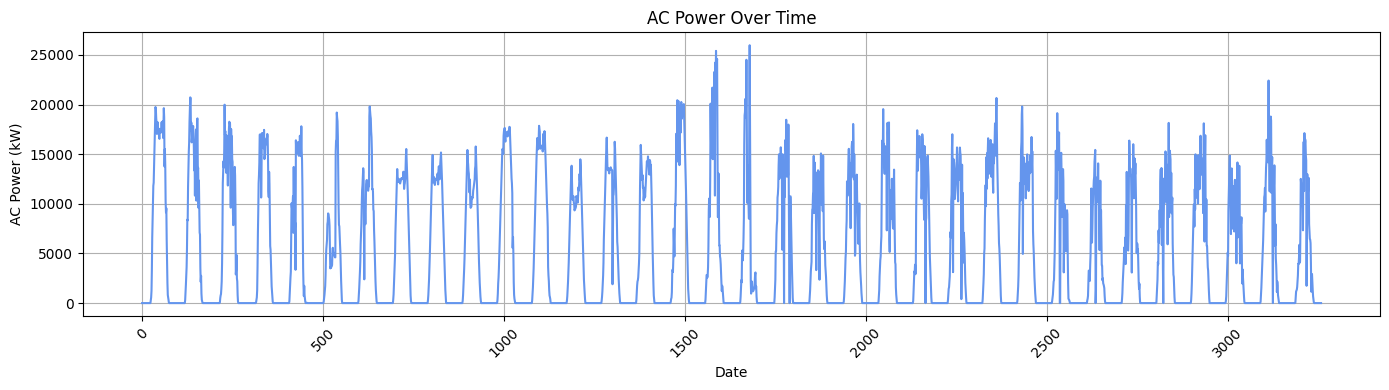

In [10]:
import numpy as np

plt.figure(figsize=(14, 4))
plt.plot(np.array(df['AC_POWER']),color="cornflowerblue")
plt.title('AC Power Over Time')
plt.xlabel('Date')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

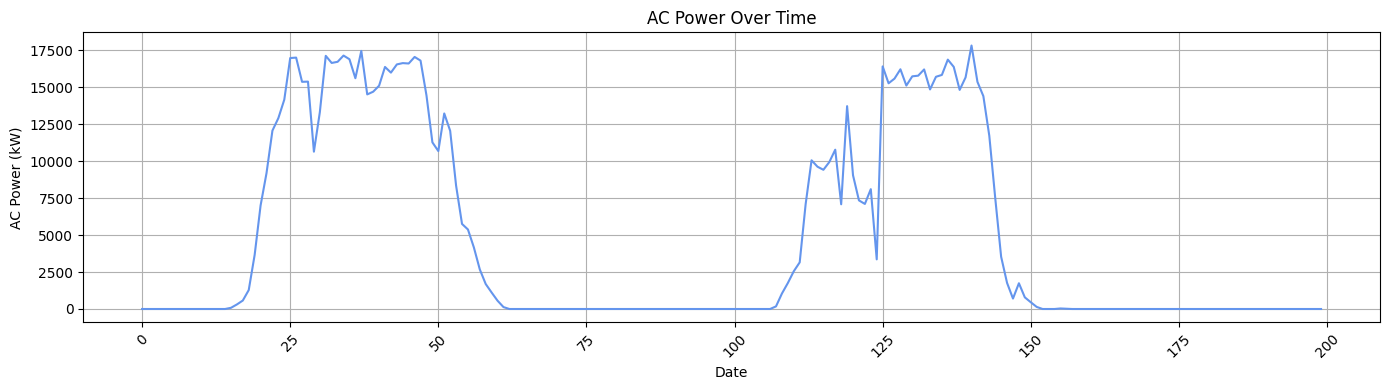

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(np.array(df['AC_POWER'])[300:500],color="cornflowerblue")
plt.title('AC Power Over Time')
plt.xlabel('Date')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

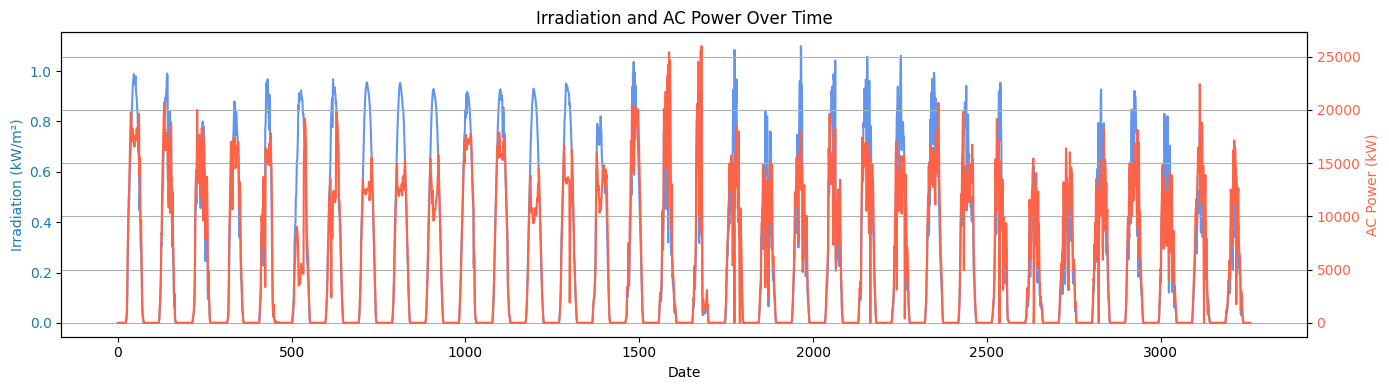

In [12]:
fig, ax1 = plt.subplots(figsize=(14, 4))

ax1.plot(np.array(df['IRRADIATION']), label='Irradiation',color="cornflowerblue")
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiation (kW/m²)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(np.array(df['AC_POWER']), color='tomato', label='AC Power')
ax2.set_ylabel('AC Power (kW)', color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title('Irradiation and AC Power Over Time')
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)

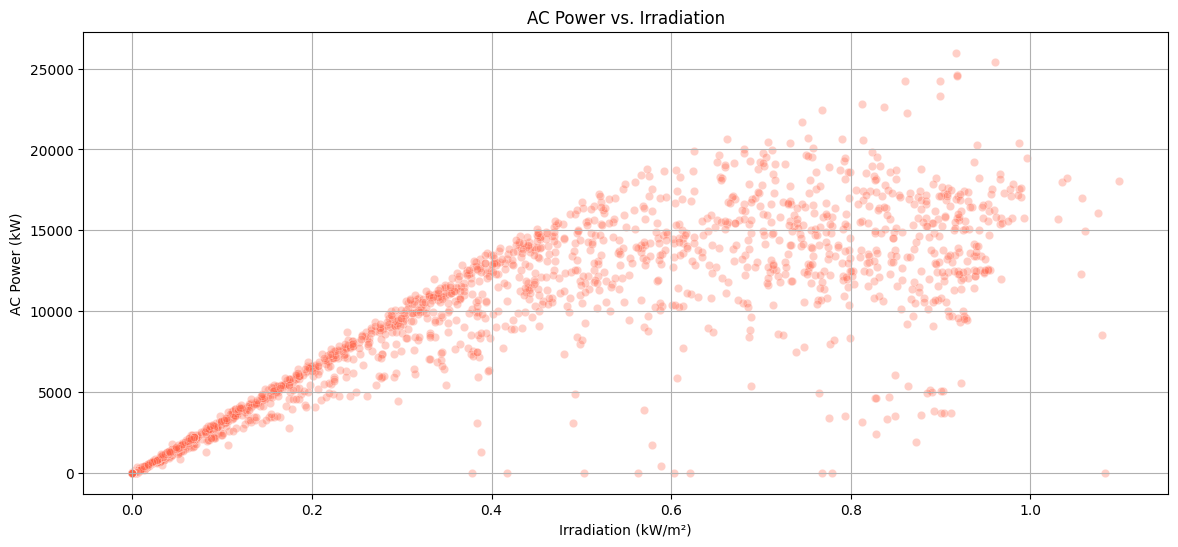

In [13]:
import seaborn as sns 

plt.figure(figsize=(14, 6))

sns.scatterplot(data=df, x='IRRADIATION', y='AC_POWER', alpha=0.3,color="tomato")

plt.title('AC Power vs. Irradiation')
plt.xlabel('Irradiation (kW/m²)')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.show()

* Uma etapa muito importante antes de realizar o treinamento de qualquer modelo de regressão consiste na análise da matriz de correlação, a qual mostra a correlação entre as variáveis. Nesse contexto, desejamos que nossas features apresentem baixa correlação, ou seja, baixa colinearidade.

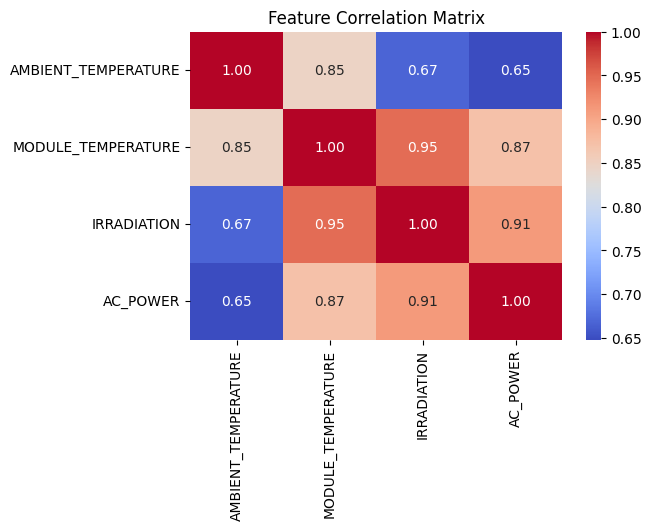

In [14]:
correlation_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']
corr_matrix = df[correlation_columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

* As variáveis apresentam uma colinearidade considerável, o que certamente irá atraplhar o treinamento dos modelos de regressão.

In [14]:
df_features = df.drop(columns=["AC_POWER","DC_POWER","DAILY_YIELD","TOTAL_YIELD","MODULE_TEMPERATURE"])

In [20]:
X = np.array(df_features)
y = np.array(df["AC_POWER"])

In [17]:
np.set_printoptions(precision=3, suppress=True, linewidth=120)
covariance_matrix = np.cov(X, rowvar=False)
print(covariance_matrix)

[[16.496  0.848]
 [ 0.848  0.098]]


In [18]:
cond_number = np.linalg.cond(covariance_matrix)
print(cond_number)

306.0091415902179


* `cond_number` representa o condicionamento da matriz de covariância, uma matriz bem condicionada apresenta valores entre 1 e 10.

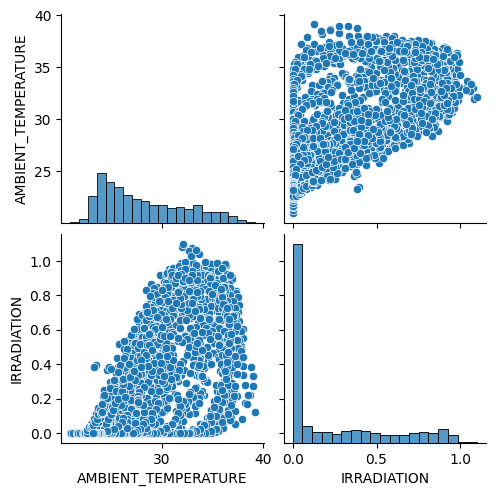

In [19]:
sns.pairplot(df_features)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [21]:
np.set_printoptions(precision=3, suppress=True, linewidth=120)
covariance_matrix = np.cov(X_scaled, rowvar=False)
print(covariance_matrix)

[[1.    0.668]
 [0.668 1.   ]]


* Normalizando os dados verifica-se que o condicionamento da matriz melhora consideravelmente.

In [22]:
cond_number = np.linalg.cond(covariance_matrix)
print(cond_number)

5.017550490989253


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
def normalize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    return data_scaled,scaler

In [25]:
X_train_scaled,X_scaler = normalize(X_train)
X_test_scaled = X_scaler.transform(X_test)
joblib.dump(X_scaler, 'models/x_scaler.joblib')


y_train_scaled, y_scaler = normalize(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))
joblib.dump(y_scaler, 'models/y_scaler.joblib')

['models/y_scaler.joblib']

In [26]:
from sklearn.metrics import root_mean_squared_error

def rmse(model,X,y_true):
    y_predicted = model.predict(X_scaler.transform(X))
    y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))
    return root_mean_squared_error(y_true, y_predicted)

In [27]:
def double_plot(first_serie,second_serie,title=""):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    if title!="":
        plt.title(title)
    plt.plot(first_serie,label="Real",color="cornflowerblue")
    plt.plot(second_serie,label="Predicted",color="tomato")
    plt.legend()   

In [28]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train_scaled, y_train_scaled)
y_predicted = linear_reg.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted)

In [29]:
joblib.dump(linear_reg, 'models/linear_reg.joblib')

['models/linear_reg.joblib']

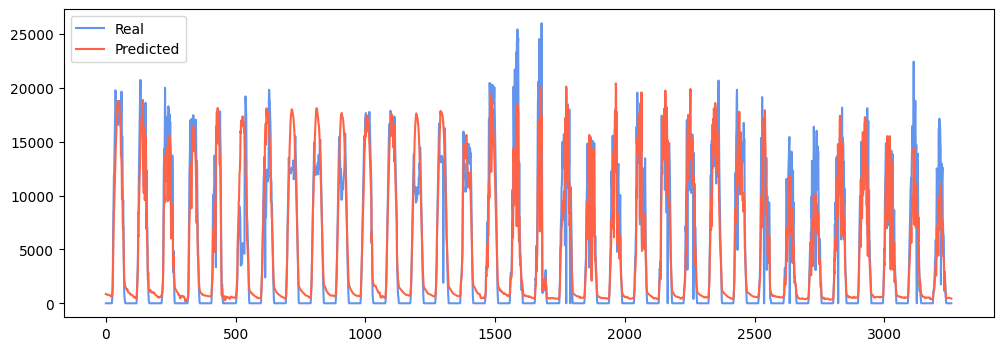

In [30]:
double_plot(y,y_predicted)

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

reg = MLPRegressor(random_state=1, max_iter=2000, tol=0.001)

param_grid = {
    'hidden_layer_sizes': [(50,),(64),(64,128),(64,32), (2,),(2,4),(2,4,8)],
    'activation': ['relu', 'tanh','identity'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, y_train_scaled.ravel())

print(grid.best_params_)
print(-grid.best_score_)


Fitting 5 folds for each of 252 candidates, totalling 1260 fits


0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=

In [32]:
mlp_regressor = grid.best_estimator_

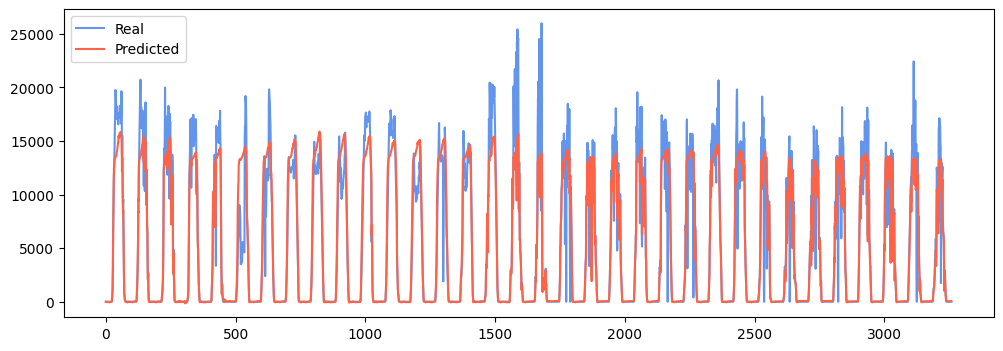

In [33]:
y_predicted = mlp_regressor.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))

double_plot(y,y_predicted)

In [34]:
joblib.dump(mlp_regressor, 'models/mlp_regressor.joblib')

['models/mlp_regressor.joblib']

In [35]:
rmse_linear_regression = rmse(linear_reg,X,y)
rmse_mlp_regressor  =  rmse(mlp_regressor,X,y)

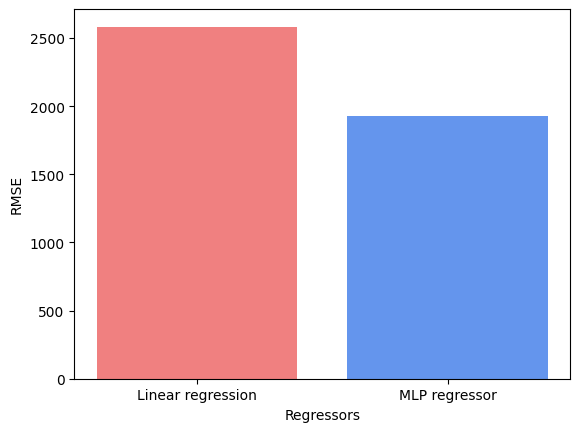

In [36]:
plt.bar([1, 2], [rmse_linear_regression, rmse_mlp_regressor], color=["lightcoral", "cornflowerblue"])
plt.xlabel("Regressors")
plt.ylabel("RMSE")
plt.xticks([1, 2], ["Linear regression", "MLP regressor"])
plt.show()


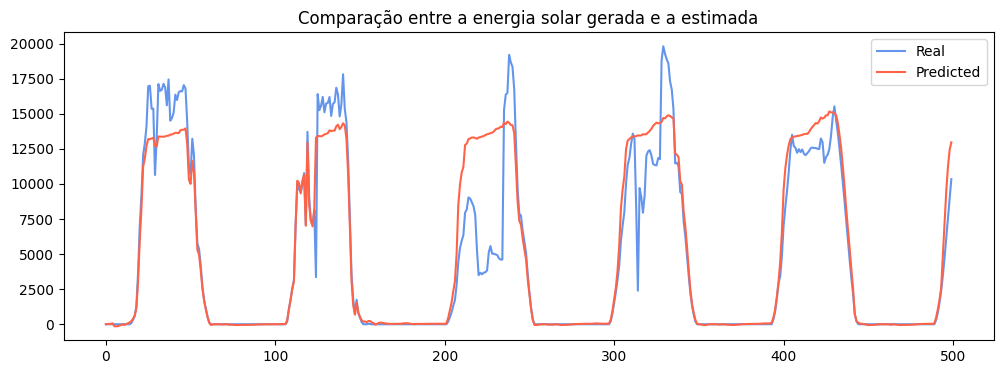

In [37]:
# mlp_regressor -> inteligência articial treinada

y_predicted = mlp_regressor.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))

double_plot(y[300:800],y_predicted[300:800],"Comparação entre a energia solar gerada e a estimada")

# Autoregressive model

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def train_weather_lstm_model(key):
    name = key
    serie = np.array(df[key])
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(serie.reshape(-1,1))
    joblib.dump(scaler,"models/"+name+"_scaler.joblib")
    window = 60
    X, Y = [], []

    for i in range(window, len(y_scaled)):
        X.append(y_scaled[i-window:i, 0])
        Y.append(y_scaled[i, 0])

    X = np.array(X)
    Y = np.array(Y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    split = int(len(X)*0.7)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window,1)))
    model.add(LSTM(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1,1))

    plt.figure(figsize=(10,5))
    plt.plot(Y_test_inv, label="Real",color="cornflowerblue")
    plt.plot(pred_inv, label="Forecast", linestyle='--',color="tomato")
    plt.legend()
    plt.show()
    model.save("models/"+name+"_lstm.keras")
    print("--------- RMSE:",np.sqrt(mean_squared_error(Y_test_inv, pred_inv)))


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0319 - val_loss: 0.0066
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_l

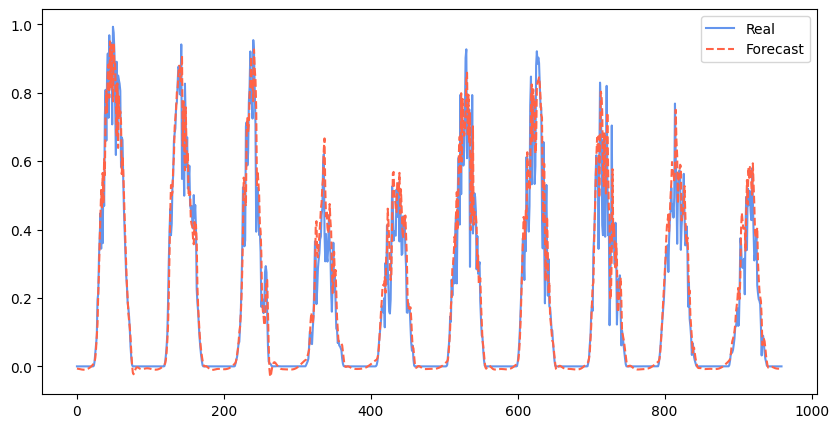

--------- RMSE: 0.07878606514980252


In [28]:
train_weather_lstm_model("IRRADIATION")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0416 - val_loss: 0.0026
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_l

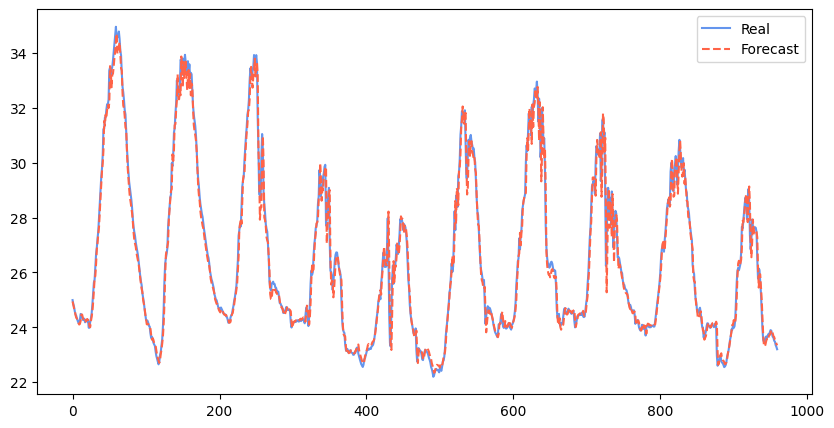

--------- RMSE: 0.41424642500334674


In [29]:
train_weather_lstm_model("AMBIENT_TEMPERATURE")

# Join Prediction weather with regression models

In [21]:
df_features

,AMBIENT_TEMPERATURE,IRRADIATION
DATE_TIME,,
2020-05-15 00:00:00,27.004764,0.0
2020-05-15 00:15:00,26.880811,0.0
2020-05-15 00:30:00,26.682055,0.0
2020-05-15 00:45:00,26.500589,0.0
2020-05-15 01:00:00,26.596148,0.0
...,...,...
2020-06-17 22:45:00,23.511703,0.0
2020-06-17 23:00:00,23.482282,0.0
2020-06-17 23:15:00,23.354743,0.0


In [66]:
from keras.models import load_model
# load trainded models

# -> load clf models
features_scaler = joblib.load("models/x_scaler.joblib")
mlp_reg = joblib.load("models/mlp_regressor.joblib")
target_scaler = joblib.load("models/y_scaler.joblib")

# -> load lstm models
temperature_lstm_scaler = joblib.load("models/AMBIENT_TEMPERATURE_scaler.joblib")
irradiation_lstm_scaler = joblib.load("models/IRRADIATION_scaler.joblib")

temperature_autoreg = load_model("models/AMBIENT_TEMPERATURE_lstm.keras")
irradiantion_autoreg = load_model("models/IRRADIATION_lstm.keras")

In [44]:
# predict weather series
temperature_serie = df_features["AMBIENT_TEMPERATURE"]
temperature_serie = np.array(temperature_serie)
temperature_serie = temperature_lstm_scaler.transform(temperature_serie.reshape(-1, 1))

irradiation_serie = df_features["IRRADIATION"]
irradiation_serie = np.array(irradiation_serie)
irradiation_serie = irradiation_lstm_scaler.transform(irradiation_serie.reshape(-1, 1))

In [124]:
def predict_weather_series(model, scaler, serie, time=100):
    window_size = 2
    
    serie_norm = serie.reshape(-1)  # garante vetor
    window = serie_norm[-window_size:]  # última janela
    
    preds = []

    for _ in range(time):
        x_input = window.reshape(1, window_size, 1)
        yhat = model.predict(x_input, verbose=0)
        preds.append(yhat[0][0])
        window = np.append(window[1:], yhat)

    preds = np.array(preds).reshape(-1, 1)
    preds_real = scaler.inverse_transform(preds)

    return preds_real.flatten()


In [138]:
def predict_weather_series(model, scaler, serie,time=100):
    window_size = 2
    
    serie_norm = serie.reshape(-1)
    
    X = []
    for i in range(len(serie_norm) - window_size):
        X.append(serie_norm[i:i+window_size])
    
    X = np.array(X).reshape(len(X), window_size, 1)

    preds = model.predict(X, verbose=0)
    preds_real = scaler.inverse_transform(preds.reshape(-1, 1))

    return preds_real.flatten()[0:time]


In [146]:
start = 0
end = 200
win = 100

predicted_irradiation = predict_weather_series(irradiantion_autoreg,irradiation_lstm_scaler,irradiation_serie[start:end],win)
predicted_temperature = predict_weather_series(temperature_autoreg,temperature_lstm_scaler,temperature_serie[start:end],win)

In [147]:
df_to_predict = pd.DataFrame({
    "AMBIENT_TEMPERATURE":predicted_temperature,
    "IRRADIATION": predicted_irradiation
})

In [148]:
X = np.array(df_to_predict)
X_scaled = features_scaler.transform(X)

In [149]:
energy_prediction = mlp_reg.predict(X_scaled)
energy_prediction = target_scaler.inverse_transform(energy_prediction.reshape(-1, 1))

Text(0, 0.5, 'Energy (kWh)')

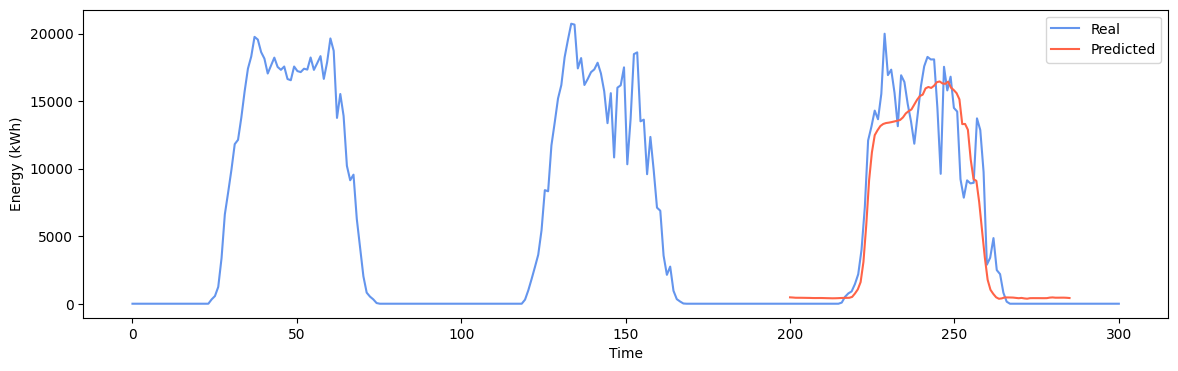

In [154]:
time_real = np.linspace(start,end+win,end+win)
time_predicted = np.linspace(end,end+win-15,win)


plt.figure(figsize=(14, 4))
plt.plot(time_real,y[start:end+win],label="Real",color="cornflowerblue")
plt.plot(time_predicted,energy_prediction,label="Predicted",color="tomato")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
